# pancreas.plasma.ev.long.RNA.biomarkers

ref:
- [https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)
- [https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/](https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/)
    * section 2 predict_class()
- [https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/)

## <span style="color:red">TODO 11/18</span>
- does tunning alpha, batch size or optimizer help. test on bestTopN. If you get improvement see if we get different features use additional tunning
- graph confusion matrix
    * [https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


## <span style="color:red">TODO</span>
- feature selection
- hyper parmeter tunning check out pipelines in [https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)
    * alpha,
    * lambda
    * batch size
- validation data set performance

## <span style="color:red">TODO</span>
- look at transcript name, transcript count, weight, and elementwise values
- look at distirbutions element wise values. histogram? swarm plot
    - PDAC
    - healthy
- label the top genes on plot, what bin? where on volcano plot?
    panel = plot volcannot
    panel add transcript labels

In [2]:
from   bme263DataVis.utilities import MatPlotLibUtilities
from keras.utils import to_categorical
from keras.utils import plot_model
from pathlib import Path

from machineLearning.machineLearningData import MachineLearningData
from machineLearning.bioMarkerModel import BioMarkerModel

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit

mplu = MatPlotLibUtilities()
mplu.loadStyle() # load our custom matplotlib style settings

dataDir = Path("../data/R/output/")

outputDir = Path(".").joinpath("output")
outputDir.mkdir(exist_ok=True)

imgOutputDir = outputDir.joinpath("img")
imgOutputDir.mkdir(exist_ok=True)

imgDir = imgOutputDir.joinpath("pancreas.plasma.ev.long.RNA.logisticRegression")
imgDir.mkdir(exist_ok=True)

# 
# tx2geneFile: file used to map transcript ids to gene ids and bio types
# rmsk == repeat mask, i.e. T.E 
# note there are two file formats
#
# top of file, 
# example from top of file has two cols separated by ','
# the first column can be split by "|" to get gene id, transcript id, .. maping
# ENST00000606857.1|ENSG00000268020.3|OTTHUMG00000185779.1|OTTHUMT00000471235.1|OR4G4P-201|OR4G4P|840|unprocessed_pseudogene|,OR4G4P
# 
# bottom of file, two columns separated by a ','
# example from bottom of file
# hg38_rmsk_ALR/Alpha_range=chr22_KI270739v1_random:50071-73985_5'pad=0_3'pad=0_strand=-_repeatMasking=none,ALR/Alpha
#
# probably easier to use 'grep'
aedwip the count data did not have TE info it was really gencode.v35.tx.to.gene.csv
tx2geneFile = "gencode.v35.ucsc.rmsk.tx.to.gene.csv"
annotationDir = Path("../../data/kimlab/genomes.annotations/gencode.35/")

tx2GenePath = annotationDir.joinpath(tx2geneFile)


# fix random seed for reproducibility
theMeaningOfLife = 42
np.random.seed(theMeaningOfLife)

# pancreas.plasma.ev.long.RNA.normalized.deseq.BIO_TYPE.counts.csv
dataFile = "pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv"
dataPath = dataDir.joinpath(dataFile)
assert dataPath.exists()

AssertionError: 

# Load data

In [5]:
!ls $dataDir


ls: ../data/R/output: No such file or directory


In [2]:
rawDF = pd.read_csv(dataPath)
rawDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131070 entries, 0 to 131069
Columns: 402 entries, Unnamed: 0 to PDAC_SRR9625101
dtypes: float64(401), object(1)
memory usage: 402.0+ MB


In [3]:
# fix col names
newNames = rawDF.columns.to_list()
# print(newNames)
newNames[0] = 'transcriptId'
rawDF.columns = newNames
rawDF.head().iloc[0:4, 0:3]

,transcriptId,healthy_SRR10080507,healthy_SRR10080508
0,ENST00000000233.10,0.000000,267.714025
1,ENST00000000412.8,170.522239,246.539604
2,ENST00000000442.11,1.305676,2.485595
3,ENST00000001008.6,48.322505,260.641801


In [4]:
df = rawDF.transpose()
df.shape

(402, 131070)

In [5]:
# select X
tmpNP = df.to_numpy()
featureList = tmpNP[0,:]
print("featureList.shape:{}".format(featureList.shape))
print("featureList:\n{}".format(featureList))

XNP = tmpNP[1:,:].astype('float64')
print("\nXNP.shape:{}".format(XNP.shape))
XNP[0:3,0:3]

featureList.shape:(131070,)
featureList:
['ENST00000000233.10' 'ENST00000000412.8' 'ENST00000000442.11' ...
 'ENST00000676456.1' 'ENST00000676457.1' 'ENST00000676459.1']

XNP.shape:(401, 131070)


array([[  0.        , 170.52223863,   1.30567618],
       [267.71402518, 246.53960412,   2.48559467],
       [321.7796839 ,   6.12436125,   0.        ]])

In [6]:
# select labels
# the labels are in the format disease_sampleID
# we want to skip the first string. it is 'transcriptId'
# labelList = hackDF.index.to_list()[1:]
labelList = df.index.to_list()[1:]
labelStr = [s.split('_')[0] for s in labelList]
print(len(labelStr))
print(labelStr[0:3])
print(labelStr[-3:])

401
['healthy', 'healthy', 'healthy']
['PDAC', 'PDAC', 'PDAC']


In [7]:
encoder = LabelEncoder()
yNP = encoder.fit_transform(labelStr)
print(yNP[0:3])
print(encoder.inverse_transform(yNP[0:3]))
print(yNP[-3:])
print(encoder.inverse_transform(yNP[-3:]))

[1 1 1]
['healthy' 'healthy' 'healthy']
[0 0 0]
['PDAC' 'PDAC' 'PDAC']


In [8]:
print("number of PDAC examples   :{}".format( sum(yNP)))
print("number of healthy examples:{}".format(len(yNP) - sum(yNP)))

number of PDAC examples   :117
number of healthy examples:284


# create 60/20/20 train/validation/test data set
- fit model using training data set
- use validation data set to tune hyper parameters
- use test data to evalute model

In [9]:
def splitData(XNP, yNP, testSize=0.4):
    # TODO use keras functions
    spliter = StratifiedShuffleSplit(
                            n_splits=1, 
                            test_size=testSize, 
                            random_state=theMeaningOfLife)

    for trainIndex, testIndex in spliter.split(XNP, yNP):
        XTrainNP = XNP[trainIndex]
        XTestNP =  XNP[testIndex]

        yTrainNP = yNP[trainIndex]
        yTestNP = yNP[testIndex]
            
    return (XTrainNP, yTrainNP, XTestNP, yTestNP)

XTrainNP, yTrainNP, XTestNP, yTestNP = splitData(XNP, yNP, testSize=0.4)
XValNP, yValNP, XTestNP, yTestNP = splitData(XTestNP, yTestNP, testSize=0.5)

## Scale data
benifits of scaling
1. scaled data tends to train faster. 
2. easier to do feature analysis. I.E. the learned weights are directly comparable.
3. often improves model stablity and performance
once we scale we get a nice learning curve. With scaling the loss and accuracy bounce all over the place

We only use the test data to set to fix the scaler. We must make sure we scale the test and validation input before making predictions using the scaler we trained on the test set

In [10]:
# normalize XNP
scaler = MinMaxScaler()

# # fit scaler on data
scaler.fit(XTrainNP)

# # apply transform
XTrainNP = scaler.transform(XTrainNP)

# inverse transform
# recover original input
#inverse = scaler.inverse_transform(XTrainNP)

XValNP = scaler.transform(XValNP)
XTestNP = scaler.transform(XTestNP)

## Train model

In [11]:
mlData = MachineLearningData(XTrainNP, yTrainNP,  XValNP, yValNP, XTestNP, yTestNP,)
mlData.name = dataFile
mlData.source = dataPath
mlData.notes = "DESeq normalized and minMax scaled transcript counts.\nref: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684\n"
print( mlData )

print("\n")
mlData.debug()

data set name:
pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

source:
../data/R/output/pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

notes:
DESeq normalized and minMax scaled transcript counts.
ref: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684



XTrain.shape:(240, 131070) yTrain.shape:(240,)
XVal.shape:(80, 131070) yVal.shape:(80,)
XTest.shape:(81, 131070) yTest.shape:(81,)


In [12]:
bioMarkerModel = BioMarkerModel(mlData, alpha=0.01, lambdaPenalty=0.0, name='simple logistitic regression')
print(bioMarkerModel)

model name:simple logistitic regression alpha:0.01 lambda:0.0
data set:
data set name:
pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

source:
../data/R/output/pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

notes:
DESeq normalized and minMax scaled transcript counts.
ref: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684



In [13]:
bioMarkerModel.run()

In [14]:
bioMarkerModel.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
logisticRegressionNeuron (De (None, 1)                 131071    
Total params: 131,071
Trainable params: 131,071
Non-trainable params: 0
_________________________________________________________________


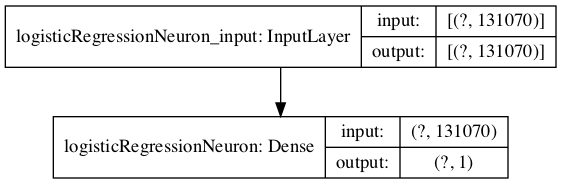

In [15]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
# returns a "jupyter notebook image" type IPython.core.display.Image

mo = imgDir.joinpath("tmp.png")
jupyterImg = plot_model(bioMarkerModel.model, to_file=mo, show_shapes=True, 
                        show_layer_names=True)
jupyterImg

## Evaluate model

In [16]:
def createPanel():
    figureWidthInInches = 8
    figureHeightInInches = 3
    fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
    panel = mplu.createPanelSameSizeAsFig(fig)
    return panel

def createFigureAndPanel(widthInInches=8, heightInInches=3):
    '''
    makes it possible to write model evaluation function that genertes
    multiple images with out having to save images to disk
    '''
    fig = plt.figure(figsize=(widthInInches, heightInInches))
    panel = mplu.createPanelSameSizeAsFig(fig)
    return (fig, panel)

In [17]:
def plotLearnCurves(model):
    '''
    todo
    '''
    
    # group data sets by metric
    # i.e. plot loss, val_loss, test_loss on same plot
    metricKeys = model.history.history.keys()
    # metricKeys: dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
 
    valKeys = filter(lambda m: 'val' in m, metricKeys)
    valKeys = list(valKeys)
    # print(valKeys)
    # ['val_loss', 'val_binary_accuracy']

    
    prefixLength = len(valKeys[0].split('_')[0]) + 1
    metrics = [vk[prefixLength:] for vk in valKeys]
    #print("metrics " + str(list(metrics)))
    # metrics ['loss', 'binary_accuracy']
    
    plotGroupedList = []
    for metric in metrics:
        groupedKeys = list(filter(lambda x: metric in x, metricKeys))
#         print('groupedKeys: ' + str(groupedKeys))
#         groupedKeys: ['loss', 'val_loss']
#         groupedKeys: ['binary_accuracy', 'val_binary_accuracy']
        plotGroupedList.append(groupedKeys)
        
    for plotGroup in plotGroupedList:
        fig, panel = createFigureAndPanel(widthInInches=4, 
                                          heightInInches=3)  
        for historyKey in plotGroup:
            panel.plot( model.history.history[historyKey], 
                       label=historyKey 
                      )
            panel.legend()
            title = "{} {}".format(model.name, plotGroup[0])
            panel.set_title(title)
            panel.set_xlabel('epochs')

   

In [18]:
def calculateResults(bioMarkerModel, X, y):
    '''
    TODO
    '''
    # evalate model on test set
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
    # returns Scalar test loss (if the model has a single output and no metrics) or 
    # list of scalars (if the model has multiple outputs and/or metrics). The attribute 
    # model.metrics_names will give you the display labels for the scalar outputs.
    testResults = bioMarkerModel.model.evaluate(X, y, verbose=0)
    
    ret = dict()
    for i in range(len(bioMarkerModel.model.metrics_names)):
        metricName = bioMarkerModel.model.metrics_names[i]
        value = testResults[i]
        ret[metricName] = value
        
    return ret

trainingResults = calculateResults(bioMarkerModel, 
                                   mlData.XTrain, mlData.yTrain)
validationResults = calculateResults(bioMarkerModel, 
                                     mlData.XVal, mlData.yVal)
testResults = calculateResults(bioMarkerModel, 
                               mlData.XTest, mlData.yTest)

print("\ntraining results:\n{}".format(trainingResults))
print("\nvalidation results:\n{}".format(validationResults))
print("\ntest results:\n{}".format(testResults))


training results:
{'loss': 0.0008934222860261798, 'binary_accuracy': 1.0}

validation results:
{'loss': 0.2670982778072357, 'binary_accuracy': 0.862500011920929}

test results:
{'loss': 0.44024205207824707, 'binary_accuracy': 0.8148148059844971}


In [19]:
def calculateConfusionMatrix(bioMarkerModel,X, y):
    '''
    TODO
    '''
    # if multi-classification
    # e.g. uses softmax in last layer activation
    # use np.argmax(model.predict(x), axis=-1)
    #
    # if binary-classification
    # e.g. uses sigmoid in last layer activation
    # use (model.predict(x) > 0.5).astype("int32")
    predicted = (bioMarkerModel.model.predict(X) > 0.5).astype("int32")

    # Compute confusion matrix
    # whose i-th row and j-th column entry indicates 
    # the number of samples with true label being i-th class and 
    # prediced label being j-th class.
    truth = y
    cm = confusion_matrix(truth, predicted)
    
    return cm

In [20]:
cmTrain = calculateConfusionMatrix(bioMarkerModel,
                                   mlData.XTrain, 
                                   mlData.yTrain)
print("training data set confusion_matrix:\ntrue label being i-th class and prediced label being j-th class\n{}".format(cmTrain))

cmVal = calculateConfusionMatrix(bioMarkerModel,
                                   mlData.XVal, 
                                   mlData.yVal)
print("\nvalidation data set confusion_matrix:\n{}".format(cmVal))

cmTest = calculateConfusionMatrix(bioMarkerModel,
                                   mlData.XTest, 
                                   mlData.yTest)
print("\ntest data set confusion_matrix:\n{}".format(cmTest))

training data set confusion_matrix:
true label being i-th class and prediced label being j-th class
[[170   0]
 [  0  70]]

validation data set confusion_matrix:
[[56  1]
 [10 13]]

test data set confusion_matrix:
[[55  2]
 [13 11]]


In [21]:
def plotTunningLearningCurves(modelsList, getPlotLabel, legendTitle):
    '''
    the models in modelList have been trained by changing a the value of
    a single paramter. for example alpha
    
    produces plots showing change over epoc in metric. 
    '''
    figList = []

    # create images but do not automatically display them
    # https://stackoverflow.com/a/35949684/4586180
    #plt.ioff()
    
    # keys are used to access model traning history
    # i.e. get loss values for each epoch, ...
    metrics = modelsList[0].history.history.keys()
        
    for currentMetric in metrics:
        fig, panel = createFigureAndPanel(widthInInches=4, 
                                          heightInInches=3)
        figList.append(fig)  
        
        for currentModel in modelsList:
            plotLabel = getPlotLabel(currentModel)
            panel.plot( currentModel.history.history[currentMetric], 
                       label=plotLabel )

            title = "{} {}".format(currentModel.name, currentMetric)
            panel.set_title(title)
            panel.set_xlabel('epochs')
            panel.legend(title=legendTitle)
            
    # reset automatically display of plots
    # https://stackoverflow.com/a/35949684/4586180
    #plt.ion()
    
    return figList

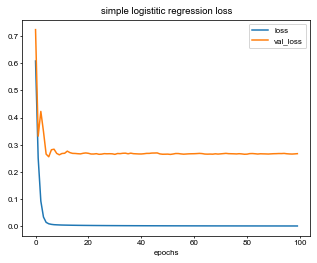

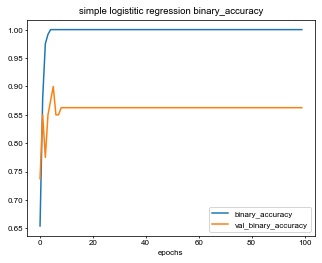

In [22]:
plotLearnCurves(bioMarkerModel)

## Tune alpha

In [23]:
alphaList = [0.0001, 0.001, 0.01, 0.1]

bioMarkerModelList = []
for alpha in alphaList:
    bioMarkerModel = BioMarkerModel(mlData, 
                                    alpha=alpha, 
                                    lambdaPenalty=0.0, 
                                    name='simple logistitic regression')
    #print(bioMarkerModel)
    bioMarkerModel.run()
    bioMarkerModelList.append( bioMarkerModel ) 

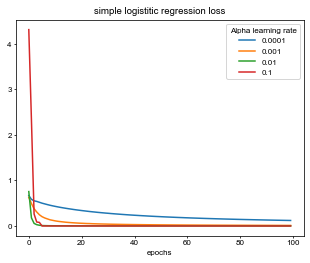

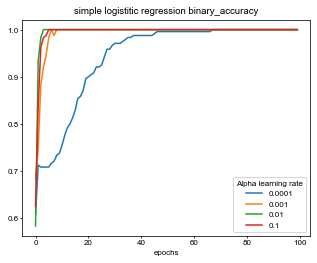

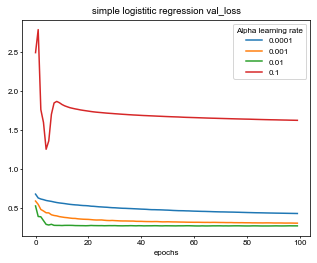

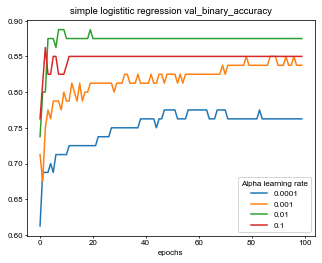

In [24]:
def getPlotAlphaLabel(bioMarkerModel):
    return bioMarkerModel.alpha

figList = plotTunningLearningCurves(modelsList=bioMarkerModelList,
                        getPlotLabel=getPlotAlphaLabel,
                        legendTitle="Alpha learning rate")

# Tune regularization

In [25]:
lamdaList = [0.0001, 0.001, 0.01, 0.1, 10]

bioMarkerModelList = []
for lamdaPenalty in lamdaList:
    bioMarkerModel = BioMarkerModel(mlData, 
                                    alpha=0.01, 
                                    lambdaPenalty=lamdaPenalty, 
                                    name='simple logistitic regression')
    #print(bioMarkerModel)
    bioMarkerModel.run()
    bioMarkerModelList.append( bioMarkerModel )

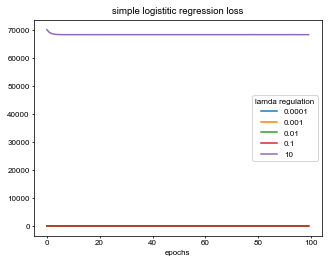

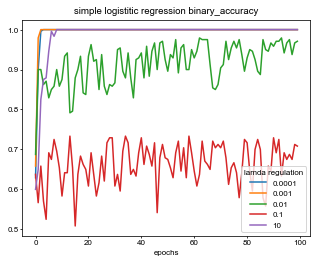

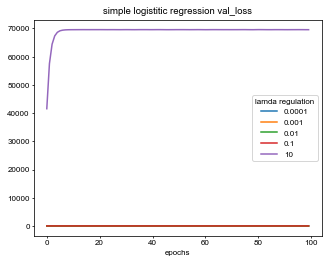

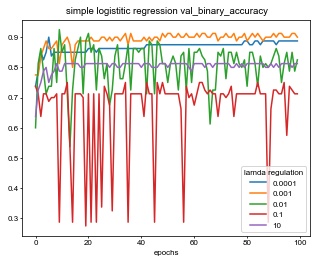

In [26]:
def getPlotLambdaLabel(bioMarkerModel):
    return bioMarkerModel.lambdaPenalty

figList = plotTunningLearningCurves(modelsList=bioMarkerModelList,
                        getPlotLabel=getPlotLambdaLabel,
                        legendTitle="lamda regulation")

# Best model
TODO:
- does batch size matter?
- try different random seeds
- try cross validation
    [https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

model name:simple logistitic regression alpha:0.01 lambda:0.001
data set:
data set name:
pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

source:
../data/R/output/pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

notes:
DESeq normalized and minMax scaled transcript counts.
ref: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684



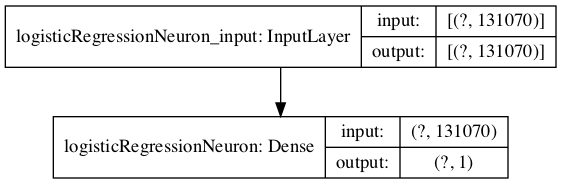

In [27]:
bestAlpha = 0.01
bestLambdaPenalty = 0.001
# use minMax scaling, 
bestBioMarkerModel = BioMarkerModel(mlData, 
                                alpha=bestAlpha, 
                                lambdaPenalty=bestLambdaPenalty, 
                                name='simple logistitic regression')

print(bestBioMarkerModel)
bestBioMarkerModel.run()

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
# returns a "jupyter notebook image" type IPython.core.display.Image

mo = imgDir.joinpath("bestBioMarkerModel.png")
jupyterImg = plot_model(bestBioMarkerModel.model, to_file=mo, show_shapes=True, 
                        show_layer_names=True)

# display the architecture image
jupyterImg

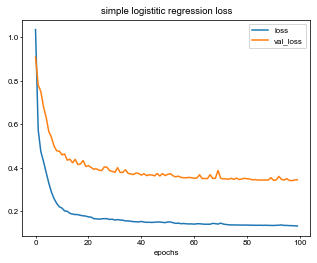

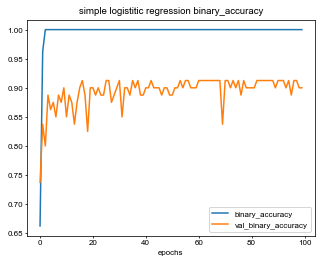

In [53]:
plotLearnCurves(bestBioMarkerModel)

In [28]:
bestTrainResults = calculateResults(bestBioMarkerModel, 
                                    mlData.XTrain, mlData.yTrain)
bestValResults = calculateResults(bestBioMarkerModel, 
                                  mlData.XVal, mlData.yVal)
bestTestResults = calculateResults(bestBioMarkerModel, 
                                   mlData.XTest, mlData.yTest)

print("\nbest training results:\n{}".format(bestTrainResults))
print("\nbest validation results:\n{}".format(bestValResults))
print("\nbest test results:\n{}".format(bestTestResults))


best training results:
{'loss': 0.1324337124824524, 'binary_accuracy': 1.0}

best validation results:
{'loss': 0.3461109399795532, 'binary_accuracy': 0.8999999761581421}

best test results:
{'loss': 0.4176841676235199, 'binary_accuracy': 0.8518518805503845}


In [29]:
bestCMTrain = calculateConfusionMatrix(bestBioMarkerModel,
                                   mlData.XTrain, 
                                   mlData.yTrain)
print("best training data set confusion_matrix:\ntrue label being i-th class and prediced label being j-th class\n{}".format(bestCMTrain))

bestCMVal = calculateConfusionMatrix(bestBioMarkerModel,
                                   mlData.XVal, 
                                   mlData.yVal)
print("\nbest validation data set confusion_matrix:\n{}".format(bestCMVal))

bestCMTest = calculateConfusionMatrix(bestBioMarkerModel,
                                   mlData.XTest, 
                                   mlData.yTest)
print("\nbest test data set confusion_matrix:\n{}".format(bestCMTest))

best training data set confusion_matrix:
true label being i-th class and prediced label being j-th class
[[170   0]
 [  0  70]]

best validation data set confusion_matrix:
[[55  2]
 [ 6 17]]

best test data set confusion_matrix:
[[56  1]
 [11 13]]


## <span style="color:red">TODO</span>
get accuracy, f1, ... recal from confusion matrix

prediction probalbities

https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/

## Feature analysis
find which featues push sigmoid activation function

### explore learned weights

In [30]:
sigmoidLayer = bestBioMarkerModel.model.get_layer(name="logisticRegressionNeuron")

In [31]:
weightsList = sigmoidLayer.get_weights()
# if we do not flatten the weights we get unexpected results from np.argsort()
weightsNP = weightsList[0].flatten()
biasNP = weightsList[1]

In [32]:
print("bias:{}".format(biasNP))

bias:[-0.0890398]


In [33]:
print("len(weights):{}".format(len(weightsNP)))
print("weights.shape{}".format(weightsNP.shape))
print("weights.flatten()shape{}".format(weightsNP.flatten().shape))
print("w[0:3]:{}".format(weightsNP[0:3]))
print("max:{}".format(np.max(weightsNP)))
print("min:{}".format(np.min(weightsNP)))
print("type(weightsNP):{}".format(type(weightsNP)))

len(weights):131070
weights.shape(131070,)
weights.flatten()shape(131070,)
w[0:3]:[-9.223918e-05 -2.069026e-05 -2.571898e-03]
max:0.20872162282466888
min:-0.14128611981868744
type(weightsNP):<class 'numpy.ndarray'>


In [34]:
numKnockedOut = np.sum( np.isclose(weightsNP, 0.) )
print("How many features did regularlization knock out? {}"
         .format(numKnockedOut))


How many features did regularlization knock out? 27


# select top features and tran new model

find largest components of Z, that is to say the features that maximal activate sigmoid

In [35]:
# split out the healthy and PDAC examples

PDAC_labelInt = encoder.transform(['PDAC'])[0]
healthyLabelInt = encoder.transform(['healthy'])[0]
print("PDAC int:{} healthy int:{}".format(PDAC_labelInt, healthyLabelInt))

selectPADCTrainingExamples = (yTrainNP == PDAC_labelInt)
PADC_XTrainNP = XTrainNP[selectPADCTrainingExamples]

# this works but does not generalize for multi-classification problems
#selectHealthyTrainingExamples = (selectPADCTrainingExamples != True)
selectHealthyTrainingExamples = (yTrainNP == healthyLabelInt)
healthyXTrainNP = XTrainNP[selectHealthyTrainingExamples]

print("PADC shape   :{}".format(PADC_XTrainNP.shape))
print("healthy shape:{}".format(healthyXTrainNP.shape))

PDAC int:0 healthy int:1
PADC shape   :(170, 131070)
healthy shape:(70, 131070)


In [36]:
def ascendingArgSort(x):
    '''
    Returns the indices that would sort an array from smallest to largets
    
    Numpy argsort does not have a ascending/decending argument
    '''
    return np.argsort(x)

def decendingArgSort(x):
    '''
    Returns the indices that would sort an array from largets to smallest
    
    Numpy argsort does not have a ascending/decending argument
    '''
    acsendingIdx = np.argsort(x)
    decendingIdx =  acsendingIdx[::-1]
    return decendingIdx

In [37]:
def binaryClassifierImportantFeatures(topN, featureList,
                                      weights, bias, labelInt, X, y):
    
    retDict = dict()
    
    selectIdx = y == labelInt
    #print("shapeIdx:{} o:5:{}".format(selectIdx.shape, selectIdx[0:5]))
    
    lableX = X[selectIdx]
    #print("lableX:{} o:5:{}".format(lableX.shape, lableX[0:5]))
    
    colAxis=0
    averageX = np.mean(lableX, axis=colAxis)
    #print("averageX.shape:{}".format(averageX.shape))

    # element wise multiplication
    zTerms = np.multiply(averageX, weights)
    #print("zTerms.shape:{}".format(zTerms.shape))
    
    if labelInt == 1:
        sortedIdx = decendingArgSort( zTerms )
    elif labelInt == 0:
        sortedIdx = ascendingArgSort( zTerms )
    else:
        print("ERROR must be binary classifier, label:{}".format(labelInt))
        
    topIdx = sortedIdx[0:topN]
    retDict["topN"] = topN
    retDict["topIdx"] = topIdx
    retDict["labelInt"] = labelInt
    retDict["trascriptIds"] = featureList[topIdx]
    retDict["averageTrascripts"] = averageX[topIdx]
    retDict["weights"] = weights[topIdx]
    retDict["zTerms"] = zTerms[topIdx]
    
    return retDict

In [38]:
topN = 5
healthyDict = binaryClassifierImportantFeatures(
                            topN=topN,
                            featureList=featureList,
                            weights=weightsNP,
                            bias=biasNP,
                            labelInt=healthyLabelInt,
                            X=XTrainNP,
                            y=yTrainNP)

print()
for key,item in healthyDict.items():
    print("{}\n{}\n".format(key,item))


topN
5

topIdx
[23559 79534 30081 18103 54243]

labelInt
1

trascriptIds
['ENST00000397426.5' 'ENST00000531978.5' 'ENST00000422514.7'
 'ENST00000374982.5' 'ENST00000481985.5']

averageTrascripts
[0.49145373 0.50641081 0.46220091 0.42442452 0.49687581]

weights
[0.20872162 0.17289326 0.16750689 0.17866094 0.13020633]

zTerms
[0.10257702 0.08755501 0.07742184 0.07582809 0.06469638]



In [39]:
PADC_Dict = binaryClassifierImportantFeatures(
                            topN=topN,
                            featureList=featureList,
                            weights=weightsNP,
                            bias=biasNP,
                            labelInt=PDAC_labelInt,
                            X=XTrainNP,
                            y=yTrainNP)

print()
for key,item in PADC_Dict.items():
    print("{}\n{}\n".format(key,item))


topN
5

topIdx
[ 9042  2852 17107    19  3500]

labelInt
0

trascriptIds
['ENST00000327490.8' 'ENST00000262033.11' 'ENST00000372688.8'
 'ENST00000005178.6' 'ENST00000265062.8']

averageTrascripts
[0.42534248 0.58564939 0.43318056 0.4076136  0.37414983]

weights
[-0.14128612 -0.09632297 -0.12603696 -0.12099006 -0.11914749]

zTerms
[-0.06009499 -0.05641149 -0.05459676 -0.04931719 -0.04457902]



## train best model

In [40]:
def selectBestData(mlData, PADC_Dict, healthyDict):
    selectFeaturesIdx = np.concatenate([PADC_Dict["topIdx"],
                                     healthyDict["topIdx"]])
    
    selectedTranscriptIds = np.concatenate([PADC_Dict["trascriptIds"],
                                     healthyDict["trascriptIds"]])
    
    bestXTrain = mlData.XTrain[:,selectFeaturesIdx]
    bestXVal   = mlData.XVal  [:,selectFeaturesIdx]
    bestXTest  = mlData.XTest [:,selectFeaturesIdx]
    
    retMlData = MachineLearningData(bestXTrain, mlData.yTrain,  
                                    bestXVal, mlData.yVal, 
                                    bestXTest, mlData.yTest)
    
    retMlData.source = mlData.source
    retMlData.name = mlData.name
    
    note1 = "\n selected transcript ids:\n{}"\
                .format(selectedTranscriptIds)
    note2 = "\n selected transcript feature idx:\n{}"\
                .format(selectFeaturesIdx)
    retMlData.notes = mlData.notes + note1 + note2
    
    return (retMlData, selectedTranscriptIds, selectFeaturesIdx)
    
topNMLData, bestTrascriptIds, bestFeatureIdx = selectBestData(mlData, PADC_Dict, healthyDict)
print(topNMLData)
print()

topNMLData.debug()

data set name:
pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

source:
../data/R/output/pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

notes:
DESeq normalized and minMax scaled transcript counts.
ref: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684

 selected transcript ids:
['ENST00000327490.8' 'ENST00000262033.11' 'ENST00000372688.8'
 'ENST00000005178.6' 'ENST00000265062.8' 'ENST00000397426.5'
 'ENST00000531978.5' 'ENST00000422514.7' 'ENST00000374982.5'
 'ENST00000481985.5']
 selected transcript feature idx:
[ 9042  2852 17107    19  3500 23559 79534 30081 18103 54243]

XTrain.shape:(240, 10) yTrain.shape:(240,)
XVal.shape:(80, 10) yVal.shape:(80,)
XTest.shape:(81, 10) yTest.shape:(81,)


## untuned top n model

In [41]:
name = "untuned top {} features logistitic regression".format(topN)
unTunedTopNModel = BioMarkerModel(topNMLData, 
#                                 alpha=bestAlpha, 
#                                 lambdaPenalty=bestLambdaPenalty, 
                                name=name)

print(unTunedTopNModel)
unTunedTopNModel.run()

model name:untuned top 5 features logistitic regression alpha:0.01 lambda:0.0
data set:
data set name:
pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

source:
../data/R/output/pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

notes:
DESeq normalized and minMax scaled transcript counts.
ref: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684

 selected transcript ids:
['ENST00000327490.8' 'ENST00000262033.11' 'ENST00000372688.8'
 'ENST00000005178.6' 'ENST00000265062.8' 'ENST00000397426.5'
 'ENST00000531978.5' 'ENST00000422514.7' 'ENST00000374982.5'
 'ENST00000481985.5']
 selected transcript feature idx:
[ 9042  2852 17107    19  3500 23559 79534 30081 18103 54243]


In [42]:
topNTrainResults = calculateResults(unTunedTopNModel, 
                                   topNMLData.XTrain, topNMLData.yTrain)
topNValResults = calculateResults(unTunedTopNModel, 
                                     topNMLData.XVal, topNMLData.yVal)
topNTestResults = calculateResults(unTunedTopNModel, 
                               topNMLData.XTest, topNMLData.yTest)

print("\nuntrained top n results:\n{}".format(topNTrainResults))
print("\nunvalidation top n results:\n{}".format(topNValResults))
print("\nuntest top n results:\n{}".format(topNTestResults))


untrained top n results:
{'loss': 0.33000853657722473, 'binary_accuracy': 0.8791666626930237}

unvalidation top n results:
{'loss': 0.4423810839653015, 'binary_accuracy': 0.762499988079071}

untest top n results:
{'loss': 0.42475810647010803, 'binary_accuracy': 0.790123462677002}


In [43]:
unTunedNCMTrain = calculateConfusionMatrix(unTunedTopNModel,
                                   topNMLData.XTrain, 
                                   topNMLData.yTrain)
print("training data set confusion_matrix:\ntrue label being i-th class and prediced label being j-th class\n{}".format(unTunedNCMTrain))

unTunedNCMVal = calculateConfusionMatrix(unTunedTopNModel,
                                   topNMLData.XVal, 
                                   topNMLData.yVal)
print("\nvalidation data set confusion_matrix:\n{}".format(unTunedNCMVal))

unTunedNCMTest = calculateConfusionMatrix(unTunedTopNModel,
                                   topNMLData.XTest, 
                                   topNMLData.yTest)
print("\ntest data set confusion_matrix:\n{}".format(unTunedNCMTest))

training data set confusion_matrix:
true label being i-th class and prediced label being j-th class
[[165   5]
 [ 24  46]]

validation data set confusion_matrix:
[[50  7]
 [12 11]]

test data set confusion_matrix:
[[52  5]
 [12 12]]


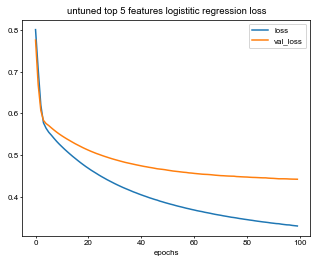

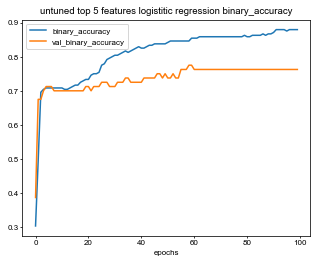

In [44]:
plotLearnCurves(unTunedTopNModel)

## Tune top n features model

In [45]:
name = "untuned top {} features logistitic regression".format(topN)
unTunedTopNModel = BioMarkerModel(topNMLData, 
#                                 alpha=bestAlpha, 
#                                 lambdaPenalty=bestLambdaPenalty, 
                                name=name)

print(unTunedTopNModel)
unTunedTopNModel.run()

model name:untuned top 5 features logistitic regression alpha:0.01 lambda:0.0
data set:
data set name:
pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

source:
../data/R/output/pancreas.plasma.ev.long.RNA.normalized.deseq.ENST.counts.csv

notes:
DESeq normalized and minMax scaled transcript counts.
ref: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684

 selected transcript ids:
['ENST00000327490.8' 'ENST00000262033.11' 'ENST00000372688.8'
 'ENST00000005178.6' 'ENST00000265062.8' 'ENST00000397426.5'
 'ENST00000531978.5' 'ENST00000422514.7' 'ENST00000374982.5'
 'ENST00000481985.5']
 selected transcript feature idx:
[ 9042  2852 17107    19  3500 23559 79534 30081 18103 54243]


## Tune top N regularization

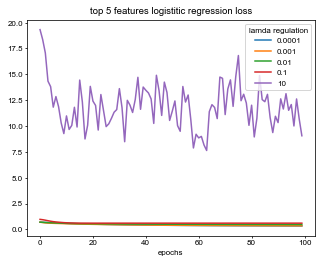

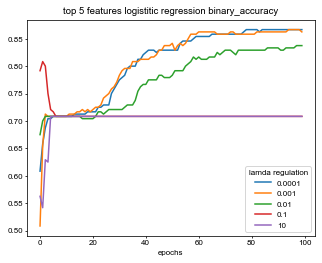

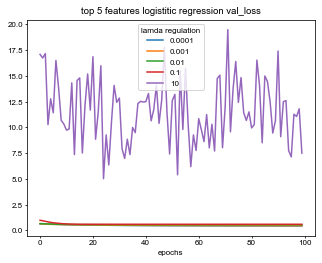

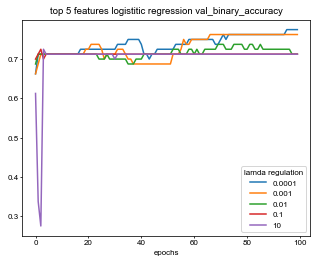

In [46]:
lamdaList = [0.0001, 0.001, 0.01, 0.1, 10]

topNModelList = []
name = "top {} features logistitic regression".format(topN)
for lamdaPenalty in lamdaList:
    topNModel = BioMarkerModel(topNMLData, 
                                alpha=0.01, 
                                lambdaPenalty=lamdaPenalty, 
                                name=name)
    #print(bioMarkerModel)
    topNModel.run()
    topNModelList.append( topNModel )

figList = plotTunningLearningCurves(modelsList=topNModelList,
                        getPlotLabel=getPlotLambdaLabel,
                        legendTitle="lamda regulation")

# winner winner chicken dinner

In [47]:
untunedAlpha = 0.01
bestName = "best top {} features logistitic regression".format(topN)
bestTopNModel = BioMarkerModel(topNMLData, 
                            alpha=untunedAlpha, 
                            lambdaPenalty=0.01, 
                            name=bestName)
#print(bioMarkerModel)
bestTopNModel.run()

In [48]:
bestTopNTrainResults = calculateResults(bestTopNModel, 
                                   topNMLData.XTrain, topNMLData.yTrain)
bestTopNValResults = calculateResults(bestTopNModel, 
                                     topNMLData.XVal, topNMLData.yVal)
bestTopNTestResults = calculateResults(bestTopNModel, 
                               topNMLData.XTest, topNMLData.yTest)

print("\nbest trained top n results:\n{}".format(bestTopNTrainResults))
print("\nbest validation top n results:\n{}".format(bestTopNValResults))
print("\nbest test top n results:\n{}".format(bestTopNTestResults))


best trained top n results:
{'loss': 0.4699086546897888, 'binary_accuracy': 0.8500000238418579}

best validation top n results:
{'loss': 0.5457499027252197, 'binary_accuracy': 0.737500011920929}

best test top n results:
{'loss': 0.5485836267471313, 'binary_accuracy': 0.790123462677002}


In [49]:
bestTopNCMTrain = calculateConfusionMatrix(bestTopNModel,
                                   topNMLData.XTrain, 
                                   topNMLData.yTrain)
print("best top n training data set confusion_matrix:\ntrue label being i-th class and prediced label being j-th class\n{}".format(bestTopNCMTrain))

bestTopNCMVal = calculateConfusionMatrix(bestTopNModel,
                                   topNMLData.XVal, 
                                   topNMLData.yVal)
print("\nbest top n validation data set confusion_matrix:\n{}".format(bestTopNCMVal))

bestTopNCMTest = calculateConfusionMatrix(bestTopNModel,
                                   topNMLData.XTest, 
                                   topNMLData.yTest)
print("\nbest top n test data set confusion_matrix:\n{}".format(bestTopNCMTest))

best top n training data set confusion_matrix:
true label being i-th class and prediced label being j-th class
[[165   5]
 [ 31  39]]

best top n validation data set confusion_matrix:
[[50  7]
 [14  9]]

best top n test data set confusion_matrix:
[[54  3]
 [14 10]]


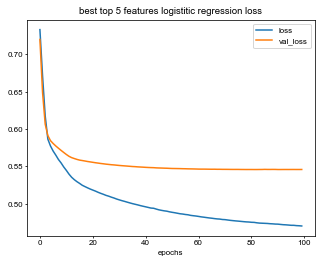

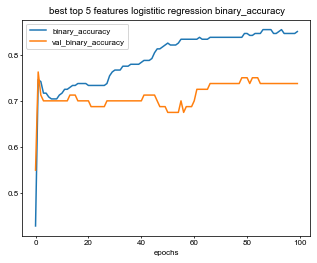

In [50]:
plotLearnCurves(bestTopNModel)

## explore best transcripts

In [51]:
grepRegex = "\|".join(bestTrascriptIds)
grepRegex

'ENST00000327490.8\\|ENST00000262033.11\\|ENST00000372688.8\\|ENST00000005178.6\\|ENST00000265062.8\\|ENST00000397426.5\\|ENST00000531978.5\\|ENST00000422514.7\\|ENST00000374982.5\\|ENST00000481985.5'

In [52]:
! grep "$grepRegex" $tx2GenePath

ENST00000265062.8|ENSG00000075785.14|OTTHUMG00000159812.3|OTTHUMT00000357479.2|RAB7A-201|RAB7A|2185|protein_coding|,RAB7A
ENST00000374982.5|ENSG00000204287.14|OTTHUMG00000031269.4|OTTHUMT00000076587.3|HLA-DRA-201|HLA-DRA|1169|protein_coding|,HLA-DRA
ENST00000005178.6|ENSG00000004799.8|OTTHUMG00000153977.3|OTTHUMT00000333298.2|PDK4-201|PDK4|3601|protein_coding|,PDK4
ENST00000372688.8|ENSG00000119335.17|OTTHUMG00000020755.4|-|SET-203|SET|801|protein_coding|,SET
ENST00000531978.5|ENSG00000166441.13|OTTHUMG00000165834.3|OTTHUMT00000386509.1|RPL27A-210|RPL27A|867|protein_coding|,RPL27A
ENST00000262033.11|ENSG00000110958.16|OTTHUMG00000170217.3|OTTHUMT00000408054.2|PTGES3-201|PTGES3|1898|protein_coding|,PTGES3
ENST00000422514.7|ENSG00000198242.14|OTTHUMG00000132684.6|OTTHUMT00000255975.2|RPL23A-204|RPL23A|970|protein_coding|,RPL23A
ENST00000327490.8|ENSG00000185262.9|OTTHUMG00000132666.5|OTTHUMT00000255920.3|UBALD2-201|UBALD2|1446|protein_coding|,UBALD2
ENST00000397426.5|ENSG00000100225.18|O